# Prepare data and libraries
Based on the Hospital Italiano de Buenos Aires - Skin Lesions Images (2019-2022).

* https://www.isic-archive.com/
* https://api.isic-archive.com/collections/251/

See separate EDA for downloading the metadata (cvs file) and imiages using the cli "isic" tool.

Criitically, this dataset has "skin type" using the Fitzpatrick scale.

* https://en.wikipedia.org/wiki/Fitzpatrick_scale

In [1]:
import sys
# If we have a version requirement, for no just make sure "more recent"
assert sys.version_info >= (3, 7)

In [2]:
# Change to top of the EFS mounted drive
import os
os.chdir('/mnt/efs/fs1/')
!pwd

/mnt/efs/fs1


In [3]:
## To load local modules, not sure if this works
#import os
#import sys
#module_path = os.path.abspath(os.path.join('..'))
#if module_path not in sys.path:
#    sys.path.append(module_path)

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

(Optional) Define the default font sizes to make the figures prettier:

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [6]:
# If you have google colab gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Not connected to a GPU


In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 32.8 gigabytes of available RAM

You are using a high-RAM runtime!


# File/Folder Testing

In [8]:
!pwd

/mnt/efs/fs1


In [9]:
#import skimage
import pathlib
import numpy as np

csv_file_name='./hiba/HIBA_dataset.csv'
meta_file_name='./hiba/SupplementaryData.csv'
root_dir_name='./hiba/images'

data_dir = pathlib.Path(root_dir_name) # NB: changing type froom str to Path
file_paths = list(data_dir.glob(f'*.JPG'))
image_count = len(file_paths)
print(f"image_count={image_count}")
for i in range(image_count):
    file_path = file_paths[i]
    print(f"file_path={file_path}")
    if( i > 10 ):
        break

image_count=1616
file_path=hiba/images/ISIC_2132963.JPG
file_path=hiba/images/ISIC_0993014.JPG
file_path=hiba/images/ISIC_4921433.JPG
file_path=hiba/images/ISIC_3063248.JPG
file_path=hiba/images/ISIC_4750998.JPG
file_path=hiba/images/ISIC_7392005.JPG
file_path=hiba/images/ISIC_6231941.JPG
file_path=hiba/images/ISIC_5272415.JPG
file_path=hiba/images/ISIC_3630590.JPG
file_path=hiba/images/ISIC_2314763.JPG
file_path=hiba/images/ISIC_3247622.JPG
file_path=hiba/images/ISIC_6634689.JPG


In [10]:
import pandas as pd
isic_metadata_df=pd.read_csv(csv_file_name)
isic_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1616 entries, 0 to 1615
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isic_id                 1616 non-null   object 
 1   attribution             1616 non-null   object 
 2   copyright_license       1616 non-null   object 
 3   age_approx              1611 non-null   float64
 4   anatom_site_general     1506 non-null   object 
 5   benign_malignant        1616 non-null   object 
 6   concomitant_biopsy      1616 non-null   bool   
 7   dermoscopic_type        1270 non-null   object 
 8   diagnosis               1616 non-null   object 
 9   diagnosis_confirm_type  1038 non-null   object 
 10  family_hx_mm            759 non-null    object 
 11  fitzpatrick_skin_type   1499 non-null   object 
 12  image_type              1616 non-null   object 
 13  lesion_id               1616 non-null   object 
 14  patient_id              1616 non-null   

In [11]:
isic_metadata_df.head()

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,concomitant_biopsy,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,fitzpatrick_skin_type,image_type,lesion_id,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
0,ISIC_6230191,Hospital Italiano de Buenos Aires,CC-BY,25.0,anterior torso,malignant,True,contact polarized,melanoma,histopathology,NaN,II,dermoscopic,IL_8124990,IP_8542863,True,640,480,male
1,ISIC_4485929,Hospital Italiano de Buenos Aires,CC-BY,65.0,anterior torso,benign,False,contact polarized,seborrheic keratosis,NaN,NaN,I,dermoscopic,IL_1921228,IP_9326183,True,2448,2448,female
2,ISIC_3079785,Hospital Italiano de Buenos Aires,CC-BY,45.0,lower extremity,benign,True,contact polarized,nevus,histopathology,False,II,dermoscopic,IL_3797557,IP_4906546,False,640,480,male
3,ISIC_9677008,Hospital Italiano de Buenos Aires,CC-BY,30.0,posterior torso,malignant,True,contact polarized,melanoma,histopathology,NaN,II,dermoscopic,IL_3556705,IP_5493434,True,1409,2900,female
4,ISIC_9129115,Hospital Italiano de Buenos Aires,CC-BY,75.0,posterior torso,benign,True,NaN,actinic keratosis,histopathology,NaN,II,clinical: overview,IL_2485486,IP_8947694,NaN,498,1026,female


In [12]:
def lookup_img_path( isic_metadata_df, file_path ):
    # NB: file_path should be str object with path to the dcm file
    #file_path = f.numpy().decode("utf-8")
    #file_path = str(f)
    imgid = file_path.split("/")[-1]
    # Get rid of extension so can exactly match the dataframe image_id
    img_name_tokens = os.path.splitext( imgid ) # hopefully more general
    img_name = img_name_tokens[0]
    #img_name = imgid.replace(".JPG", "")
    #print( img_name )
    row = isic_metadata_df.loc[ isic_metadata_df["isic_id"] == img_name ]
    # Should be only one row, i.e. img_name exists and is unique in the dataframe
    #print( f"FOUND {row.shape}" )
    
    #print( row )
    #num_rows = row.shape[0]
    #if( num_rows > 0 ):
    # lesion_id      image_id  dx    dx_type   age   sex     localization
    # the row lookup returns a dataframe or series, but just one value, use iat
    patient_id = row["patient_id"].iat[0]
    image_name = row["isic_id"].iat[0]
    diagnosis  = row["diagnosis"].iat[0]
    benign  = row["benign_malignant"].iat[0]
    age     = row["age_approx"].iat[0]
    sex     = row["sex"].iat[0]
    location = row["anatom_site_general"].iat[0]
    skin_type = row["fitzpatrick_skin_type"].iat[0]

    sample = {'file_path': file_path, 'image_name': image_name, 'patient_id': patient_id,
              'diagnosis': diagnosis, 'benign_malignant': benign, 'age': age, 'sex': sex,
              'location': location, 'skin_type':skin_type}
    return sample
      

In [13]:
example_metadata = lookup_img_path( isic_metadata_df, "./hiba/images/ISIC_9999251.JPG" )
print(example_metadata)

{'file_path': './hiba/images/ISIC_9999251.JPG', 'image_name': 'ISIC_9999251', 'patient_id': 'IP_3975331', 'diagnosis': 'actinic keratosis', 'benign_malignant': 'benign', 'age': 65.0, 'sex': 'female', 'location': 'lower extremity', 'skin_type': 'II'}


## 1. Custom Dataset
Based on https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Based on https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [14]:
import pathlib
import numpy as np

In [15]:
csv_file_name='./hiba/HIBA_dataset.csv'
meta_file_name='./hiba/SupplementaryData.csv'
root_dir_name='./hiba/images'

data_dir = pathlib.Path(root_dir_name) # NB: changing type froom str to Path
file_paths = list(data_dir.glob('*.JPG'))
image_count = len(file_paths)
print(image_count)
for i in range(image_count):
    file_path = file_paths[i]
    print(f"file_path={file_path}")
    if( i > 10 ):
        break

1616
file_path=hiba/images/ISIC_2132963.JPG
file_path=hiba/images/ISIC_0993014.JPG
file_path=hiba/images/ISIC_4921433.JPG
file_path=hiba/images/ISIC_3063248.JPG
file_path=hiba/images/ISIC_4750998.JPG
file_path=hiba/images/ISIC_7392005.JPG
file_path=hiba/images/ISIC_6231941.JPG
file_path=hiba/images/ISIC_5272415.JPG
file_path=hiba/images/ISIC_3630590.JPG
file_path=hiba/images/ISIC_2314763.JPG
file_path=hiba/images/ISIC_3247622.JPG
file_path=hiba/images/ISIC_6634689.JPG


In [16]:
import pathlib
from torch.utils.data import Dataset
#from torchvision.io import read_image

# Three ways of reading images (two in the tutorials)
# Transforms are designed for Scikit-image, however, decided to use Torchvision
# Torchvision returns tensor (can be converted to PIL for displaying)
# Scikit-image returns numpy skimage.io.imread(os.path.join('data/faces/', img_name)
# PIL returns pillow object me thinks PIL.Image.open(image_path)
# https://stackoverflow.com/questions/68207510/how-to-use-torchvision-io-read-image-with-image-as-variable-not-stored-file
#import skimage

import pandas as pd
import os

class IsicDataset(Dataset):
    """Isic dataset"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the (JPG) images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.metadata_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # We really only need a list of str file paths, no need for root_dir
        # more of a convenience.  Support both root_dir or list of filepaths
        if( type(root_dir) == str ):
            #print("USING ROOT DIR")
            # The dataframe metadata may have  more records than we have
            # files in the directory, so use the files
            #data_path = pathlib.Path(root_dir) # NB: changing type from str to Path
            #self.file_paths = list(data_path.glob('*/*.jpg'))
    
            # Prefer pure Python str to posixpath, causes lots of problems otherwise
            data_path = pathlib.Path(root_dir) # NB: changing type from str to Path
            self.file_paths = list()
            for posixpath in list(data_path.glob('*.JPG')):
                file_path = str(posixpath)
                # Check to make sure we have target
                row = self.lookup_path( file_path )
                skin_type = row['skin_type']
                # If row['skin_type'] is nan, then not even a str!!!
                #print(f"skin_type={row['skin_type']}")
                if( type( skin_type ) == str and len(skin_type) > 0  ):
                    self.file_paths.append( file_path )
        elif( type(root_dir) == list ):
            #print("USING LIST")
            self.file_paths = root_dir
        else:
            raise ValueError(f"Unsupported type for root_dir {type(root_dir)}")
        
        
        self.image_count = len(self.file_paths)
        #print(image_count)
        #for i in range(image_count):
        #    file_path = file_paths[i]
        # Manually map target to ints   (required for models)
        #self.class_names = ['benign', 'malignant']
        self.class_names = ['I', 'II', 'III', 'IV' , 'V', 'VI']
        
    
    def __len__(self):
        return self.image_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        file_path = self.file_paths[idx]
        row = self.lookup_path( file_path )

        #img_name = sample['imgid']
        #image = io.imread(img_name)
        # Frankly not sure why we don't just store as Pytorch tensor
        # example stores as a numpy image and then transforms
        # In any cases, the dimensions are different and so code is not compatible
        # specifically the resize and crop are written for numpy :(
        # Perhaps one day can rewrite for tensors but fine for now
        #image_tensor = torchvision.io.read_image( str(file_path) )
        #sample['image'] = image_tensor
        
        image_np = skimage.io.imread(file_path) # dtype=uint8
        # [[[209 155 181]
        #  [210 154 183]
        #  [209 154 183]
        #  ...
        # need float32, also imshow, if float, expects  between [0,1]
        # This is also perhaps nice for training as normalised.
        image_np = np.float32(image_np)/255.0

        # Change  the target from {benign,malignant} to the skin_type {I,II,III,IV,V,VI}
        #label = self.class_names.index( row['benign_malignant'] )
        label = self.class_names.index( row['skin_type'] )
        sample = (image_np, label)

        # apply any transforms, e.g. resize, crop
        if self.transform:
            sample = self.transform(sample)

        return sample

    def get_class_names( self ):
        return self.class_names

    def get_class( self, index ):
        return self.class_names[index]

    def get_index( self, file_path ):
        return self.file_paths.index(file_path)

    def get_file_path( self, idx ):
        return self.file_paths[idx]
    
    def lookup_path( self, file_path ):
        """
        file_path (type Path) of the file (e.g. ISIC_0034214)
        returns dict {'file_path','image_name','patient_id','diagnosis',
            'benign_malignant', 'age', 'sex', 'location', 'skin_type'}
        """
        # NB: file_path should be str object with path to the dcm file
        #file_path = f.numpy().decode("utf-8")
        #file_path = str(f)
        imgid = file_path.split("/")[-1]
        # Get rid of extension so can exactly match the dataframe image_id
        img_name_tokens = os.path.splitext( imgid ) # hopefully more general
        img_name = img_name_tokens[0]
        #img_name = imgid.replace(".JPG", "")
        #print( img_name )
        row = isic_metadata_df.loc[ isic_metadata_df["isic_id"] == img_name ]
        # Should be only one row, i.e. img_name exists and is unique in the dataframe
        #print( f"FOUND {row.shape}" )
        
        #print( row )
        #num_rows = row.shape[0]
        #if( num_rows > 0 ):
        # lesion_id      image_id  dx    dx_type   age   sex     localization
        # the row lookup returns a dataframe or series, but just one value, use iat
        patient_id = row["patient_id"].iat[0]
        image_name = row["isic_id"].iat[0]
        diagnosis  = row["diagnosis"].iat[0]
        benign     = row["benign_malignant"].iat[0]
        age        = row["age_approx"].iat[0]
        sex        = row["sex"].iat[0]
        location   = row["anatom_site_general"].iat[0]
        skin_type  = row["fitzpatrick_skin_type"].iat[0]
    
        sample = {'file_path': file_path, 'image_name': image_name, 'patient_id': patient_id,
                  'diagnosis': diagnosis, 'benign_malignant': benign, 'age': age, 'sex': sex,
                  'location': location, 'skin_type':skin_type}
        return sample

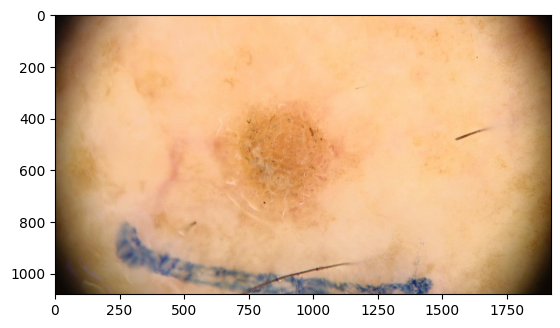

float32


In [17]:
import skimage
def show_skin_image(image_np):
    """Show image"""
    plt.imshow(image_np)
    
    #new_PIL_image = transform.to_pil_image(image_tensor) 
    #plt.imshow(new_PIL_image)
    
    #plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
image_np = skimage.io.imread('hiba/images/ISIC_9999251.JPG')
image_np = np.float32(image_np)/255.0
#pixel values are either between [0,255] or [0.0,1.0]
# Since we nornalised, they are [0.0,1.0]
show_skin_image(image_np)
plt.show()
print(image_np.dtype)

0 (4032, 3024, 3) 1


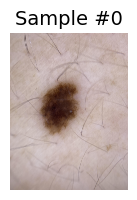

1 (4032, 3024, 3) 1


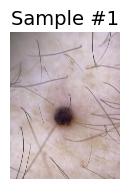

2 (480, 640, 3) 1


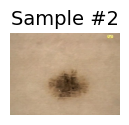

3 (1080, 1920, 3) 3


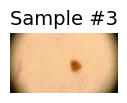

In [18]:
isic_dataset = IsicDataset(csv_file=csv_file_name, root_dir=root_dir_name)

fig = plt.figure()

images_to_show = 4
for i, sample in enumerate(isic_dataset):
    image_tensor, label = sample
    print(i, image_tensor.shape, label)
    
    ax = plt.subplot(1, images_to_show, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i}')
    ax.axis('off')
    show_skin_image( image_tensor )
    
    if i == images_to_show -  1:
        plt.show()
        break

In [19]:
import numpy as np
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = skimage.transform.resize(image, (new_h, new_w))

        return (img, label)


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        return (image, label)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        #print(image_np.dtype) = uint8
        # default numpy type is float64, causes issues as models expect float32 :(
        return (torch.from_numpy(image), label)

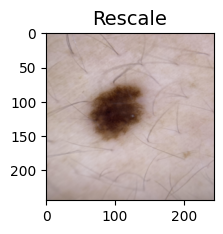

In [20]:
#from torchvision.transforms import v2

#scale = Rescale(256)
scale = Rescale( (244,244) )
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = isic_dataset[0]
#for i, tsfrm in enumerate([scale, crop, composed]):
for i, tsfrm in enumerate([scale]):
    image, label = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_skin_image(image)

plt.show()

Iterating through the dataset
Let’s put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

An image is read from the file on the fly

Transforms are applied on the read image

Since one of the transforms is random, data is augmented on sampling

We can iterate over the created dataset with a for i in range loop as before.

In [21]:
transformed_dataset = IsicDataset(  csv_file=csv_file_name,
                                   root_dir=root_dir_name,
                                   transform=transforms.Compose([
                                       Rescale( (224,224) ),
                                       #RandomCrop(224),
                                       ToTensor()
                                    ]))

for i, sample in enumerate(transformed_dataset):
    image, label = sample
    print(i, image.size())

    if i == 3:
        break

0 torch.Size([3, 224, 224])
1 torch.Size([3, 224, 224])
2 torch.Size([3, 224, 224])
3 torch.Size([3, 224, 224])


However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

Batching the data

Shuffling the data

Load the data in parallel using multiprocessing workers.

torch.utils.data.DataLoader is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

0 2
1 2
2 2
3 2


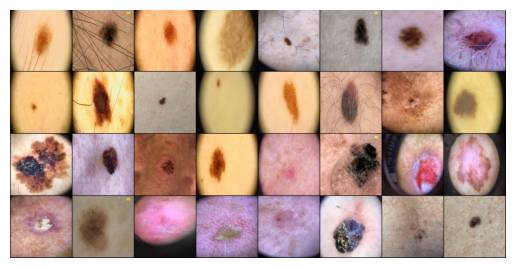

In [22]:
from torch.utils.data import DataLoader
from torchvision import utils

num_threads = 16 # assuming 16 CPUs

batch_size = 32
dataloader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, labels_batch = sample_batched
    batch_size = len(images_batch)
    #print(f"batch_size={batch_size}")
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change ``num_workers`` to 0.

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    # NB sample_batched should always be 2, two lists
    #   list of batch_size for images
    #   list of batch_size for labels
    print(i_batch, len(sample_batched) ) 

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [23]:
class_names = transformed_dataset.get_class_names()

total = len(transformed_dataset)
train = int(0.7 * total)
test  = total - train
print(  f"class_names={class_names} target size {len(class_names)}" )
print(  f"train={train}  test={test}" )
train_set, val_set = torch.utils.data.random_split(transformed_dataset, [train, test])

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_threads)

class_names=['I', 'II', 'III', 'IV', 'V', 'VI'] target size 6
train=1049  test=450


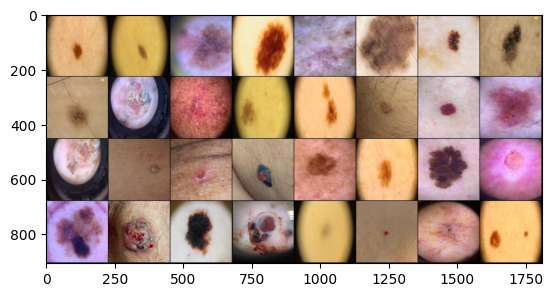

III   II    II    III   II    II    II    II    II    II    II    II    III   II    II    II    II    II    II    II    II    III   II    II    I     II    II    II    II    II    II    III  


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

# 2. Define a Convolutional Neural Network

In [25]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Expects images of h=224, w=224
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        # 28 = 224 / 2/ 2 /2 
        self.fc4 = nn.Linear(128*28*28, 512)
        self.act4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.5)

        self.fc5 = nn.Linear(512, 256)
        self.act5 = nn.ReLU()
        self.drop5 = nn.Dropout(0.5)

        self.fc6 = nn.Linear(256, len(class_names))
        # Omitted because loss function 
        #self.softmax = nn.Softmax( dim=len(class_names) ) # expect  only one dim

        # Initialise
        self._init_weights(self.conv1)
        self._init_weights(self.conv2)
        self._init_weights(self.conv3)
        self._init_weights(self.fc4)
        self._init_weights(self.fc5)
        self._init_weights(self.fc6)
        #self._init_weights(self.softmax)

    def _init_weights(self, module):
        #print(f"Initialising module {module}")
        # https://saturncloud.io/blog/how-to-initialize-weights-in-pytorch-a-guide-for-data-scientists/
        # https://wandb.ai/wandb_fc/tips/reports/How-to-Initialize-Weights-in-PyTorch--VmlldzoxNjcwOTg1
        nn.init.xavier_normal_(module.weight)
        # nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu') # He
        #if isinstance(module, nn.Linear):
        #    module.weight.data.normal_(mean=0.0, std=1.0)
        #    if module.bias is not None:
        #        module.bias.data.zero_()

    
    def forward(self, x):
        verbose = False
        #=========================#
        # input 3x224x224
        x = self.act1(self.conv1(x))
        # output 32x224x224

        # input 32x224x224 
        x = self.pool1(x)
        # output 32x112x112
        if verbose: print(f"output conv1 {x.shape}")

        #=========================#
        # input 32x112x112
        x = self.act2(self.conv2(x))
        # input 64x112x112
        
        # input 64x112x112
        x = self.pool2(x)
        # output 64x56x56
        if verbose: print(f"output conv2 {x.shape}")

        #=========================#
        # input 64x56x56
        x = self.act3(self.conv3(x))
        # input 128x56x56
        
        # input 128x56x56
        x = self.pool3(x)
        # output 128x28x28
        if verbose: print(f"output conv3 {x.shape}")

        #=========================#
        # input 128x28x28
        x = self.flat(x)
        # output (128x28x28)
        if verbose: print(f"output flatten {x.shape}")

        #=========================#
        # input (128x28x28)
        x = self.act4(self.fc4(x))
        x = self.drop4(x)
        # output (512)
        if verbose: print(f"output fully connect 4 {x.shape}")

        #=========================#
        # input (512)
        x = self.act5(self.fc5(x))
        x = self.drop5(x)
        #  output (256)
        if verbose: print(f"output fully connect 5 {x.shape}")

        #=========================#
        # input (256)
        x = self.fc6(x)
        #  output (7)
        if verbose: print(f"output fully connect 6 {x.shape}")
        
        # Finally pass through a softmax
        #x = self.softmax(x)
        #if verbose: print(f"output softmax {x.shape}")
        return x


model = Net()

## 3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

### Training on GPU?
Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [62]:
num_epochs = 20
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 16 == 0:
            print(f'    epoch {epoch+1} batch {i}: loss: {running_loss:.6f}')
        #if i % 100 == 99:    # print every 100 batches
        #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.6f}')
        #    running_loss = 0.0
    print(f'epoch {epoch + 1}/{num_epochs}: loss: {running_loss:.6f}')

print('Finished Training')

    epoch 1 batch 0: loss: 0.527868
    epoch 1 batch 16: loss: 11.092386
    epoch 1 batch 32: loss: 22.171937
epoch 1/20: loss: 22.171937
    epoch 2 batch 0: loss: 0.661440
    epoch 2 batch 16: loss: 10.964231
    epoch 2 batch 32: loss: 22.242809
epoch 2/20: loss: 22.242809
    epoch 3 batch 0: loss: 0.789024
    epoch 3 batch 16: loss: 10.951359
    epoch 3 batch 32: loss: 21.447091
epoch 3/20: loss: 21.447091
    epoch 4 batch 0: loss: 0.717065
    epoch 4 batch 16: loss: 11.722866
    epoch 4 batch 32: loss: 21.907322
epoch 4/20: loss: 21.907322
    epoch 5 batch 0: loss: 0.554325
    epoch 5 batch 16: loss: 11.358707
    epoch 5 batch 32: loss: 22.146097
epoch 5/20: loss: 22.146097
    epoch 6 batch 0: loss: 0.631130
    epoch 6 batch 16: loss: 11.536799
    epoch 6 batch 32: loss: 21.810937
epoch 6/20: loss: 21.810937
    epoch 7 batch 0: loss: 0.775741
    epoch 7 batch 16: loss: 11.210041
    epoch 7 batch 32: loss: 22.180120
epoch 7/20: loss: 22.180120
    epoch 8 batch 0:

Let’s quickly save our trained model:

In [63]:
PATH = './hiba_skin_model.pth'
torch.save(model.state_dict(), PATH)

## 5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

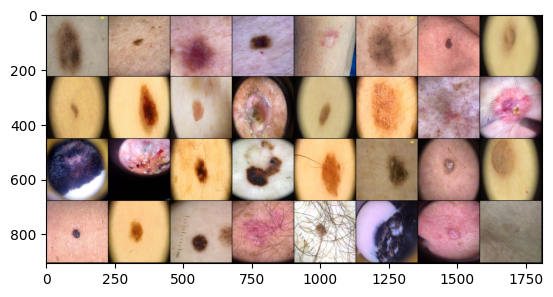

GroundTruth:  II    II    II    II    II    II    II    II    II    III   III   II    II    III   II    II    II    II    III   II    III   II    II    II    I     III   II    II    II    II    II    II   


In [64]:
testloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=num_threads)
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [65]:
model = Net()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

In [66]:
outputs = model(images)

The outputs are probablities for the 7 classes. The higher the prob for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [67]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{class_names[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  II    II    II    II    II    II    II    II    II    III   II    II    II    III   II    II    II    II    III   II    III   II    II    II    II    III   II    II    II    II    II    II   


The results seem pretty good. (humm)

Let us look at how the network performs on the whole dataset.

In [68]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(val_set)} test images: {100 * correct // total} %')

Accuracy of the network on the 450 test images: 82 %


What are the classes that performed well, and the classes that did not perform well:

In [69]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    pred_for_class = total_pred[classname]
    print( f"    {correct_count} / {pred_for_class}" )
    accuracy = 0.0
    if( pred_for_class > 0 ):
        accuracy = 100 * float(correct_count) / pred_for_class
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    0 / 36
Accuracy for class: I     is 0.0 %
    322 / 328
Accuracy for class: II    is 98.2 %
    44 / 80
Accuracy for class: III   is 55.0 %
    0 / 6
Accuracy for class: IV    is 0.0 %
    0 / 0
Accuracy for class: V     is 0.0 %
    0 / 0
Accuracy for class: VI    is 0.0 %


# Exploratory Data  Analysis

In [64]:
metadata_df=pd.read_csv(csv_file_name)
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1616 entries, 0 to 1615
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isic_id                 1616 non-null   object 
 1   attribution             1616 non-null   object 
 2   copyright_license       1616 non-null   object 
 3   age_approx              1611 non-null   float64
 4   anatom_site_general     1506 non-null   object 
 5   benign_malignant        1616 non-null   object 
 6   concomitant_biopsy      1616 non-null   bool   
 7   dermoscopic_type        1270 non-null   object 
 8   diagnosis               1616 non-null   object 
 9   diagnosis_confirm_type  1038 non-null   object 
 10  family_hx_mm            759 non-null    object 
 11  fitzpatrick_skin_type   1499 non-null   object 
 12  image_type              1616 non-null   object 
 13  lesion_id               1616 non-null   object 
 14  patient_id              1616 non-null   

In [65]:
#To analyse basics of Dataset we study first 5 rows of HAAM10000 Dataset
metadata_df.head()

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,concomitant_biopsy,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,fitzpatrick_skin_type,image_type,lesion_id,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
0,ISIC_6230191,Hospital Italiano de Buenos Aires,CC-BY,25.0,anterior torso,malignant,True,contact polarized,melanoma,histopathology,NaN,II,dermoscopic,IL_8124990,IP_8542863,True,640,480,male
1,ISIC_4485929,Hospital Italiano de Buenos Aires,CC-BY,65.0,anterior torso,benign,False,contact polarized,seborrheic keratosis,NaN,NaN,I,dermoscopic,IL_1921228,IP_9326183,True,2448,2448,female
2,ISIC_3079785,Hospital Italiano de Buenos Aires,CC-BY,45.0,lower extremity,benign,True,contact polarized,nevus,histopathology,False,II,dermoscopic,IL_3797557,IP_4906546,False,640,480,male
3,ISIC_9677008,Hospital Italiano de Buenos Aires,CC-BY,30.0,posterior torso,malignant,True,contact polarized,melanoma,histopathology,NaN,II,dermoscopic,IL_3556705,IP_5493434,True,1409,2900,female
4,ISIC_9129115,Hospital Italiano de Buenos Aires,CC-BY,75.0,posterior torso,benign,True,NaN,actinic keratosis,histopathology,NaN,II,clinical: overview,IL_2485486,IP_8947694,NaN,498,1026,female


In [66]:
#Checking for NA
metadata_df.isna().isna().sum()

isic_id                   0
attribution               0
copyright_license         0
age_approx                0
anatom_site_general       0
benign_malignant          0
concomitant_biopsy        0
dermoscopic_type          0
diagnosis                 0
diagnosis_confirm_type    0
family_hx_mm              0
fitzpatrick_skin_type     0
image_type                0
lesion_id                 0
patient_id                0
personal_hx_mm            0
pixels_x                  0
pixels_y                  0
sex                       0
dtype: int64

In [67]:
metadata_df.describe(include='all')

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,concomitant_biopsy,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,fitzpatrick_skin_type,image_type,lesion_id,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
count,1616,1616,1616,1611.000000,1506,1616,1616,1270,1616,1038,759,1499,1616,1616,1616,885,1616.000000,1616.000000,1611
unique,1616,1,1,NaN,8,2,2,1,10,2,2,4,3,1246,623,2,NaN,NaN,2
top,ISIC_7874486,Hospital Italiano de Buenos Aires,CC-BY,NaN,head/neck,benign,True,contact polarized,nevus,histopathology,False,II,dermoscopic,IL_6821221,IP_7035571,False,NaN,NaN,female
freq,1,1616,1616,NaN,418,865,1036,1270,602,1036,603,1085,1270,6,63,499,NaN,NaN,855
mean,NaN,NaN,NaN,59.615146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1929.376856,1869.875000,NaN
std,NaN,NaN,NaN,18.697683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1098.770536,1349.868136,NaN
min,NaN,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.000000,152.000000,NaN
25%,NaN,NaN,NaN,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,889.250000,900.750000,NaN
50%,NaN,NaN,NaN,65.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1920.000000,1080.000000,NaN
75%,NaN,NaN,NaN,75.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3024.000000,3024.000000,NaN


In [68]:
import seaborn as sns

/tmp/ipykernel_1594/3258167228.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="fitzpatrick_skin_type", kind="count", palette='bright', data=metadata_df)


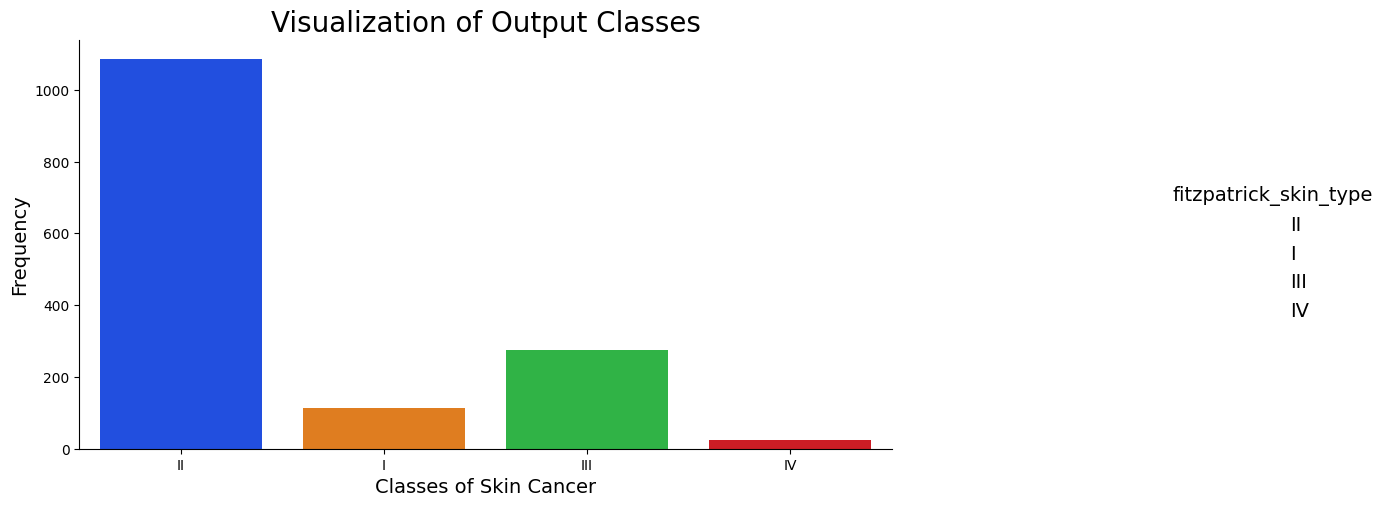

In [70]:
# We need to predict the cancer type, let's check the distribution of the values
g = sns.catplot(x="fitzpatrick_skin_type", kind="count", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Visualization of Output Classes', fontsize=20)
g.set_xlabels('Classes of Skin Cancer', fontsize=14)
g.set_ylabels('Frequency', fontsize=14)
plt.show()

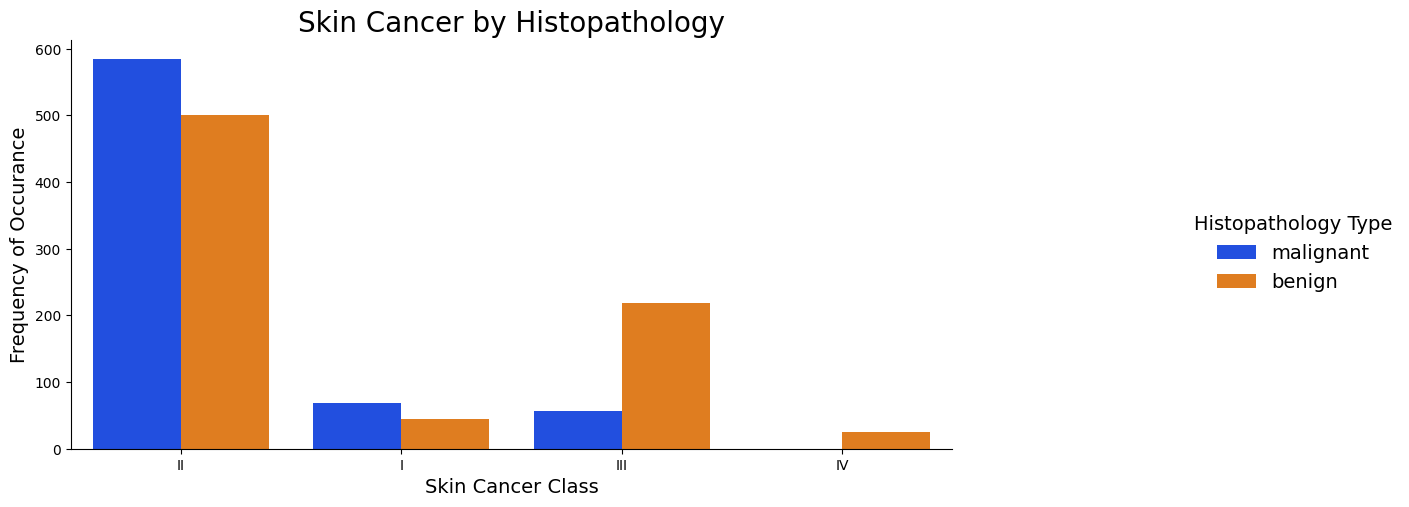

In [74]:
#Skin Cancer is confirmed via Hispathology, let's check the breakdown for each type
g = sns.catplot(x="fitzpatrick_skin_type", kind="count", hue="benign_malignant", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Histopathology', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Histopathology Type')
plt.show()

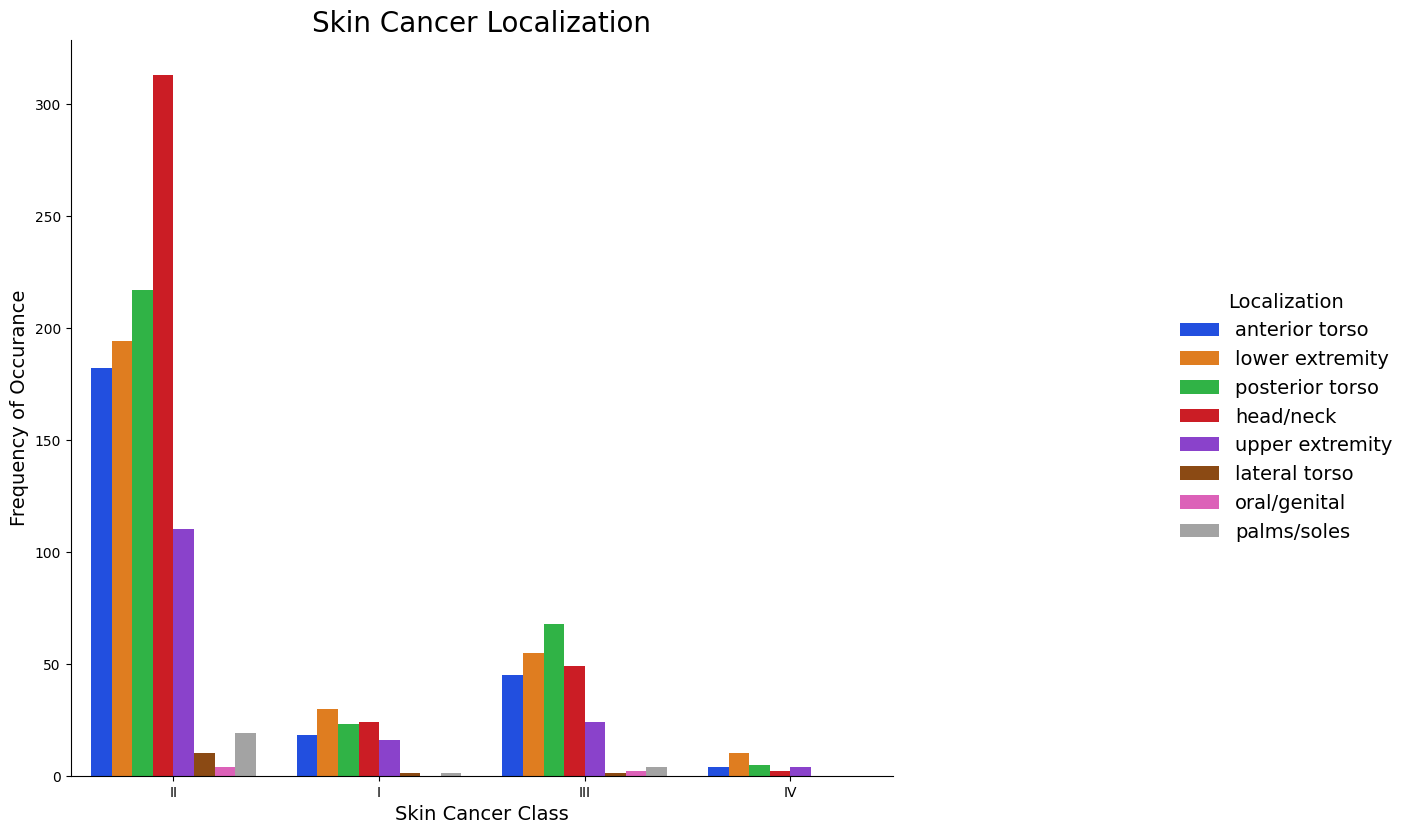

In [76]:
# Skin Cancer occurence body localization
g = sns.catplot(x="fitzpatrick_skin_type", kind="count", hue="anatom_site_general", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')
plt.show()

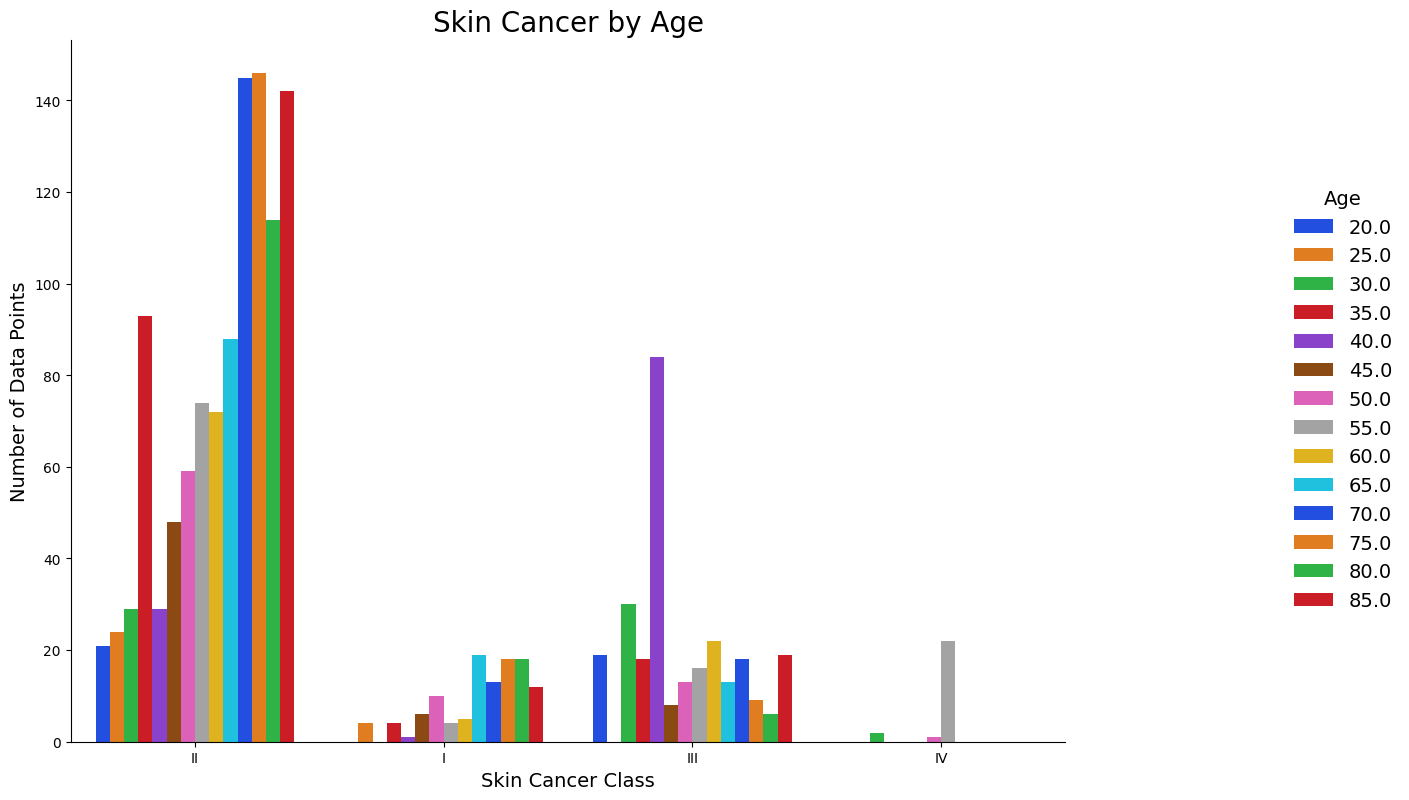

In [77]:
# Skin Cancer occurence by Age
g = sns.catplot(x="fitzpatrick_skin_type", kind="count", hue="age_approx", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Age')
plt.show()

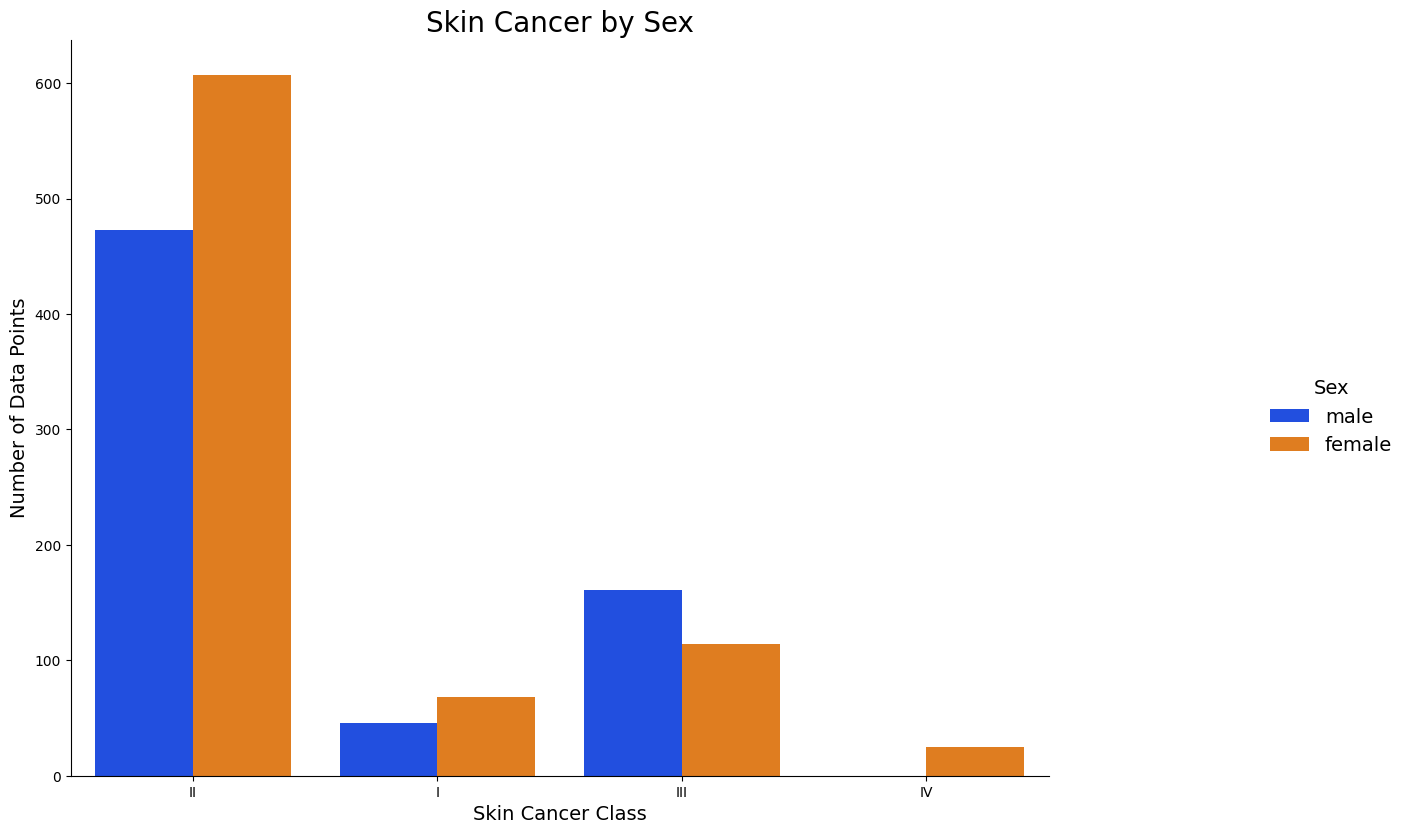

In [78]:
# Skin Cancer occurence by Sex
g = sns.catplot(x="fitzpatrick_skin_type", kind="count", hue="sex", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Sex', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Sex')
plt.show()

# Fairness Analysis
Create a custom CNN model and train on the data.  Evaluate using the validation set to estimate the model's accuracy.

In [ ]:
# Read in again, makes this section more independent
metadata_df=pd.read_csv(csv_file_name)
metadata_df.head()

In [ ]:
metadata_sample_df = metadata_df.sample(batch_size*2, random_state=123456)
print(class_names)
metadata_sample_df.head()

In [ ]:
# See https://discuss.pytorch.org/t/how-to-retrieve-the-sample-indices-of-a-mini-batch/7948/19
# https://discuss.pytorch.org/t/how-does-one-obtain-indicies-from-a-dataloader/16847/7
def dataset_with_indices(cls):
    """
    Modifies the given Dataset class to return a tuple data, target, index
    instead of just data, target.
    """
    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index
    
    return type(cls.__name__, (cls,), {
        '__getitem__': __getitem__,
    })
IsicDatasetWithIndices = dataset_with_indices(IsicDataset)
#dataset = MNISTWithIndices('~/datasets/mnist')

Create a new dataset with all the images.

In [ ]:
eval_file_paths = list()
for index_df, row in metadata_sample_df.iterrows():
    # health_small/nv/ISIC_0027761.jpg
    dx = row['dx']
    image_id = row['image_id']
    #file_path = f"{root_dir_name}/{dx}/{image_id}.jpg"
    file_path = f"ham/health/{dx}/{image_id}.jpg"
    eval_file_paths.append(file_path)
    #print( f"{index}: dx={dx}  image_id={image_id} file_path={file_path}" )

# This results in data = (img, label, index) instead of just (img,label)
# The index is lookup into the dataset, e.g. eval_dataset[index]
eval_dataset = IsicDatasetWithIndices( csv_file=csv_file_name,
                           root_dir=eval_file_paths,
                           transform=transforms.Compose([
                               Rescale( (224,224) ),
                               #RandomCrop(224),
                               ToTensor()
                            ]))
print(f"Evaluation Dataset contains {len(eval_dataset)} instances")
print(f"Dataframe has {metadata_sample_df.shape}")
print(f"List eval_file_paths has {len(eval_file_paths)}")

In [ ]:
evalloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
dataiter = iter(evalloader)
images, labels, indexes = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
y_true = list()
y_pred = list()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
k = 0
with torch.no_grad():
    for data in evalloader:
        # My hope is that the loader (we can shuffle because index is returned) and dataframe are "aligned"
        # Confirmed that this is indeed the case with the modified datase "with indices"
        images, labels, indexes = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #print(f"=== Batch === {predicted}")
        for i in range(len(predicted)):
            output = outputs[i]
            pred  = predicted[i]
            label = labels[i]
            index = indexes[i]
            
            y_true.append(label)
            y_pred.append(pred)

            # Sanity check
            file_path = eval_dataset.get_file_path(index)
            sample = eval_dataset.lookup_path(file_path)
            if( class_names[label] != sample['dx'] ):
                raise ValueError(f"Dataset and loader misaligned for {sample} and index {index}")
            #print(f"output={output} label={label} ({class_names[label]}) pred={pred} index={index}")
            # Make sure order of y_true and y_pred align with dataframe (used to create dataset)
            #print(f"sample={sample}")
            #print(f"row={metadata_sample_df.iloc[int(index)]}")

#print(f'Accuracy of the network on the {len(eval_dataset)} test images: {100 * correct // total} %')

mycorrect = 0
mytotal = 0
for i in range(len(y_true)):
    if( y_pred[i] == y_true[i] ):
        mycorrect += 1
    mytotal += 1
print(f"Total={mytotal} correct={mycorrect} my accuracy={mycorrect/mytotal:.3f}")

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(class_names)
metadata_sample_df["dx"] = le.transform(metadata_sample_df["dx"])
sex_labels = np.array( ['male','female','unknow'] ) # NOT SURE WHY THIS IS NOT WORKING, female should be 1
le.fit(sex_labels)
metadata_sample_df["sex"] = le.transform( metadata_sample_df["sex"] )
#metadata_df = pd.get_dummies(metadata_df, columns=['sex', 'localization'])

#metadata_sample_df = pd.get_dummies(metadata_df, columns=['dx'])
metadata_sample_df.drop(["image_id", "lesion_id", "dx_type", "localization"], axis=1, inplace=True)
metadata_sample_df.head(n=10)

In [ ]:
# https://stackoverflow.com/questions/64506977/calculate-group-fairness-metrics-with-aif360
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

dataset = StandardDataset(metadata_sample_df, 
                          label_name='dx', 
                          favorable_classes=[1,4], 
                          protected_attribute_names=['sex'], 
                          privileged_classes=[[1]])

def fair_metrics(dataset, y_pred):
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference(),
             'disparate_impact': metric_pred.disparate_impact(),
             'equal_opportunity_difference': classified_metric.equal_opportunity_difference()}
        
    return result


fair_metrics(dataset, np.array(y_pred) )